In [1]:
from astropy.io import ascii
import pylab as plt
%matplotlib inline

from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
from scipy.interpolate import interp1d

import pystan
import numpy as np
import xidplus
from xidplus import moc_routines
import pickle
output_folder='./'
prfsize=np.array([18.15,25.15,36.3])
#use Gaussian2DKernel to create prf (requires stddev rather than fwhm hence pfwhm/2.355)
from astropy.convolution import Gaussian2DKernel
pixsize=[6,8,10]
##---------fit using Gaussian beam-----------------------
prf250=Gaussian2DKernel(prfsize[0]/2.355,x_size=101,y_size=101)
prf250.normalize(mode='peak')
prf350=Gaussian2DKernel(prfsize[1]/2.355,x_size=101,y_size=101)
prf350.normalize(mode='peak')
prf500=Gaussian2DKernel(prfsize[2]/2.355,x_size=101,y_size=101)
prf500.normalize(mode='peak')
pind250=np.arange(0,101,1)*1.0/pixsize[0] #get 250 scale in terms of pixel scale of map
pind350=np.arange(0,101,1)*1.0/pixsize[1] #get 350 scale in terms of pixel scale of map
pind500=np.arange(0,101,1)*1.0/pixsize[2] #get 500 scale in terms of pixel scale of map

/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
from astropy.io import ascii, fits
import pylab as plt
%matplotlib inline
from astropy import wcs


import numpy as np
import xidplus
from xidplus import moc_routines
import pickle

In [3]:
#Folder containing maps
imfolder=xidplus.__path__[0]+'/../test_files/'

pswfits=imfolder+'cosmos_itermap_lacey_07012015_simulated_observation_w_noise_PSW_hipe.fits.gz'#SPIRE 250 map
pmwfits=imfolder+'cosmos_itermap_lacey_07012015_simulated_observation_w_noise_PMW_hipe.fits.gz'#SPIRE 350 map
plwfits=imfolder+'cosmos_itermap_lacey_07012015_simulated_observation_w_noise_PLW_hipe.fits.gz'#SPIRE 500 map


#Folder containing prior input catalogue
catfolder=xidplus.__path__[0]+'/../test_files/'
#prior catalogue
prior_cat='lacey_07012015_MillGas.ALLVOLS_cat_PSW_COSMOS_test.fits'


#output folder
output_folder='./'

In [4]:
#-----250-------------
hdulist = fits.open(pswfits)
im250phdu=hdulist[0].header
im250hdu=hdulist[1].header

im250=hdulist[1].data*1.0E3
nim250=hdulist[2].data*1.0E3
w_250 = wcs.WCS(hdulist[1].header)
pixsize250=3600.0*w_250.wcs.cd[1,1] #pixel size (in arcseconds)
hdulist.close()
#-----350-------------
hdulist = fits.open(pmwfits)
im350phdu=hdulist[0].header
im350hdu=hdulist[1].header

im350=hdulist[1].data*1.0E3
nim350=hdulist[2].data*1.0E3
w_350 = wcs.WCS(hdulist[1].header)
pixsize350=3600.0*w_350.wcs.cd[1,1] #pixel size (in arcseconds)
hdulist.close()
#-----500-------------
hdulist = fits.open(plwfits)
im500phdu=hdulist[0].header
im500hdu=hdulist[1].header
im500=hdulist[1].data*1.0E3
nim500=hdulist[2].data*1.0E3
w_500 = wcs.WCS(hdulist[1].header)
pixsize500=3600.0*w_500.wcs.cd[1,1] #pixel size (in arcseconds)
hdulist.close()

In [5]:
xx,yy=np.meshgrid(np.arange(-0.004,0.004,0.001)+150.12008667,np.arange(-0.004,0.004,0.001)+2.21504807472)
inra=xx.reshape(-1)+np.random.normal(0,0.0004,xx.size)
indec=yy.reshape(-1)+np.random.normal(0,0.0004,yy.size)

In [6]:
1/3600.0

0.0002777777777777778

In [7]:
#---prior250--------
prior250=xidplus.prior(im250,nim250,im250phdu,im250hdu)#Initialise with map, uncertianty map, wcs info and primary header
prior250.prior_cat(inra,indec,prior_cat)#Set input catalogue
prior250.prior_bkg(-5.0,5)#Set prior on background (assumes Guassian pdf with mu and sigma)
#---prior350--------
prior350=xidplus.prior(im350,nim350,im350phdu,im350hdu)
prior350.prior_cat(inra,indec,prior_cat)
prior350.prior_bkg(-5.0,5)

#---prior500--------
prior500=xidplus.prior(im500,nim500,im500phdu,im500hdu)
prior500.prior_cat(inra,indec,prior_cat)
prior500.prior_bkg(-5.0,5)

In [8]:
#pixsize array (size of pixels in arcseconds)
pixsize=np.array([pixsize250,pixsize350,pixsize500])
#point response function for the three bands
prfsize=np.array([18.15,25.15,36.3])
#use Gaussian2DKernel to create prf (requires stddev rather than fwhm hence pfwhm/2.355)
from astropy.convolution import Gaussian2DKernel

##---------fit using Gaussian beam-----------------------
prf250=Gaussian2DKernel(prfsize[0]/2.355,x_size=101,y_size=101)
prf250.normalize(mode='peak')
prf350=Gaussian2DKernel(prfsize[1]/2.355,x_size=101,y_size=101)
prf350.normalize(mode='peak')
prf500=Gaussian2DKernel(prfsize[2]/2.355,x_size=101,y_size=101)
prf500.normalize(mode='peak')

pind250=np.arange(0,101,1)*1.0/pixsize[0] #get 250 scale in terms of pixel scale of map
pind350=np.arange(0,101,1)*1.0/pixsize[1] #get 350 scale in terms of pixel scale of map
pind500=np.arange(0,101,1)*1.0/pixsize[2] #get 500 scale in terms of pixel scale of map

prior250.set_prf(prf250.array,pind250,pind250)#requires psf as 2d grid, and x and y bins for grid (in pixel scale)
prior350.set_prf(prf350.array,pind350,pind350)
prior500.set_prf(prf500.array,pind500,pind500)

In [9]:
prior250.get_pointing_matrix()
prior350.get_pointing_matrix()
prior500.get_pointing_matrix()

/Users/pdh21/HELP/XID_plus/xidplus/prior.py:196: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  dx = -np.rint(self.sx[s]).astype(long) + self.pindx[(paxis1 - 1.) / 2] + self.sx_pix
/Users/pdh21/HELP/XID_plus/xidplus/prior.py:198: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  dy = -np.rint(self.sy[s]).astype(long) + self.pindy[(paxis2 - 1.) / 2] + self.sy_pix


In [10]:
prior250.sim[:]=np.random.normal(0,2,(prior250.snpix))
prior350.sim[:]=np.random.normal(0,2,(prior350.snpix))
prior500.sim[:]=np.random.normal(0,2,(prior500.snpix))

prior250.snim[:]=2.0
prior350.snim[:]=2.0
prior500.snim[:]=2.0


In [11]:
from xidplus import posterior_maps as postmaps
flux=np.random.uniform(low=10.0, high=20.0,size=prior250.nsrc)
rmap_tmp=postmaps.ymod_map(prior250,flux)
prior250.sim[:]+=rmap_tmp.reshape(-1)
rmap_tmp=postmaps.ymod_map(prior350,flux)
prior350.sim[:]+=rmap_tmp.reshape(-1)
rmap_tmp=postmaps.ymod_map(prior500,flux)
prior500.sim[:]+=rmap_tmp.reshape(-1)

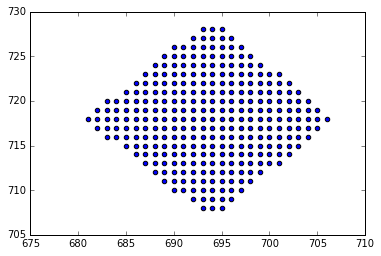

In [12]:
plt.scatter(prior250.sx_pix,prior250.sy_pix)
test2=np.zeros((np.max(prior250.sx_pix)+1,np.max(prior250.sy_pix)+1))
test2[prior250.sx_pix,prior250.sy_pix]=prior250.sim

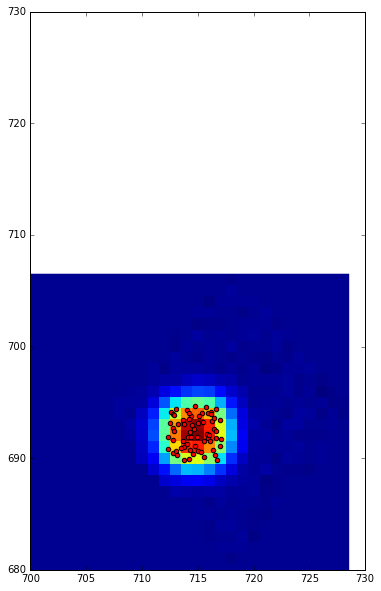

In [13]:

plt.figure(figsize=(10,10))
plt.imshow(test2,interpolation='nearest')
plt.xlim(700,730)
plt.ylim(680,730)
plt.scatter(prior250.sy,prior250.sx,c='red')

In [14]:
prior250.get_pointing_matrix_unknown_psf()

/Users/pdh21/HELP/XID_plus/xidplus/prior.py:267: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  f = interpolate.interp1d(self.pindx[0:(paxis1 + 1.) / 2],np.arange((paxis1 + 1.) / 2.),kind='nearest')


In [15]:
from xidplus.stan_fit import SPIRE
fit=SPIRE.all_bands_PSF(prior250,prior350,prior500,51,np.arange(51),iter=1000)

/Users/pdh21/HELP/XID_plus/notebooks/XID+SPIRE_PSF.pkl found. Reusing


In [16]:
posterior=xidplus.posterior_stan(fit,[prior250,prior350,prior500])


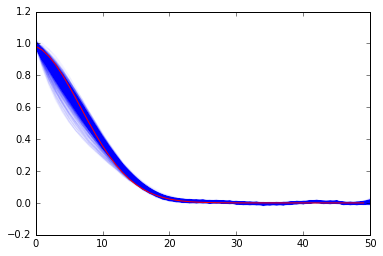

In [17]:
for i in range(0,2000):
    plt.plot(posterior.stan_fit[:,:,-52:-1].reshape(2000,51)[i,:],'b',alpha=0.02,linestyle='-')
plt.plot()
plt.plot(prior250.prf[51:,51],'r')

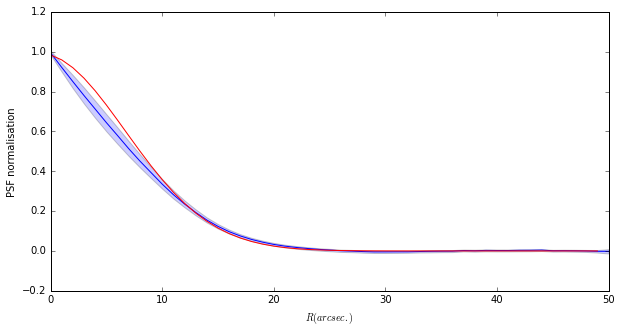

In [55]:
plt.figure(figsize=(10,5))
psf_fit=np.percentile(posterior.stan_fit[:,:,-52:-1].reshape(2000,51),[16.0,50.0,84.0],axis=0)
plt.plot(psf_fit[1,:],'b')
plt.fill_between(np.arange(0,51),psf_fit[0,:],psf_fit[2,:],alpha=0.2)
plt.plot(prior250.prf[51:,51],'r')
plt.xlabel(r'$R (arcsec.)$')
plt.ylabel(r'PSF normalisation')

(array([ 933.,  327.,  319.,  151.,   91.,   67.,   42.,   38.,   14.,   18.]),
 array([  177.33062361,   279.45438814,   381.57815267,   483.7019172 ,
          585.82568174,   687.94944627,   790.0732108 ,   892.19697533,
          994.32073987,  1096.4445044 ,  1198.56826893]),
 <a list of 10 Patch objects>)

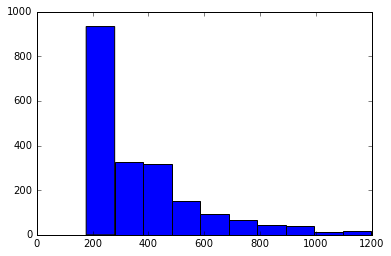

In [167]:
plt.hist(prior250.bkg[0]+prior250.bkg[1]*posterior.stan_fit[:,:,8].reshape(-1))

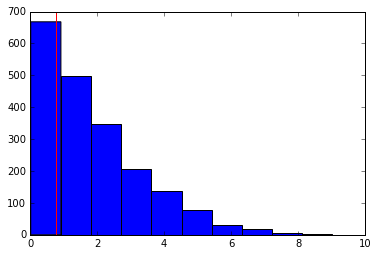

In [21]:
plt.hist(posterior.stan_fit[:,:,8].reshape(-1))
plt.axvline(flux[8], c='r')

In [124]:
posterior.param_names[-53]

u'sigma_conf_pmw'

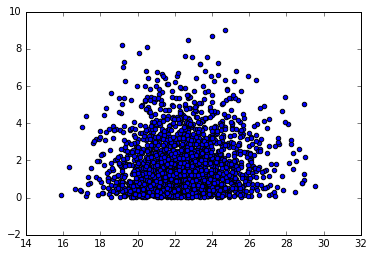

In [22]:
plt.scatter(posterior.stan_fit[:,:,7].reshape(-1),posterior.stan_fit[:,:,8].reshape(-1))

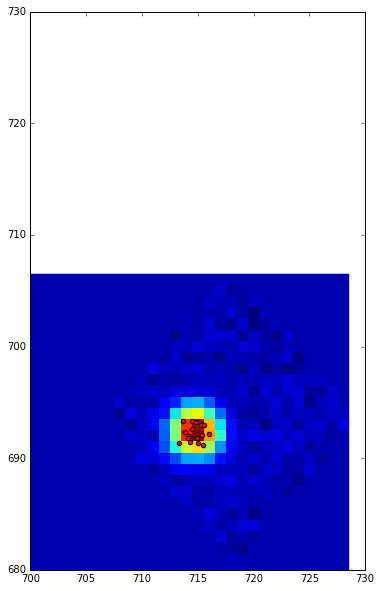

In [40]:
plt.figure(figsize=(10,10))
plt.imshow(test2,interpolation='nearest')
plt.xlim(700,730)
plt.ylim(680,730)
plt.scatter(prior250.sy,prior250.sx,c='red')

Is the problem here that its modelling the noise? As the flux distribution is uniform, it would rather give more flux to source, and reduce point spread function. BUT the flux distribution is uniform here. So if its modelling noise, how whould that manifest itself?

(array([   4.,   11.,   74.,  258.,  539.,  517.,  403.,  151.,   36.,    7.]),
 array([-1.25985645, -1.06651984, -0.87318323, -0.67984663, -0.48651002,
        -0.29317342, -0.09983681,  0.0934998 ,  0.2868364 ,  0.48017301,
         0.67350961]),
 <a list of 10 Patch objects>)

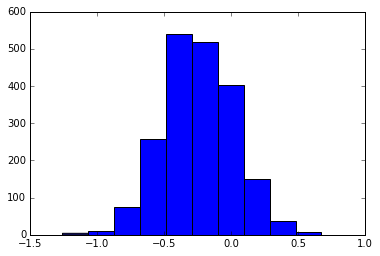

In [26]:
plt.hist(prior250.bkg[0]+prior250.bkg[1]*posterior.stan_fit[:,:,prior250.nsrc].reshape(-1))